# **Problem Statement:** Automated Trading Strategy using DDQN		  

## **Background:**
In finance, automated trading systems are used to execute trades in financial markets based on predefined rules. These systems often employ quantitative strategies that rely on analyzing market data to make trading decisions. However, designing effective trading strategies manually can be challenging due to the complex and dynamic nature of financial markets.

## **Objective:**
The objective is to develop an automated trading system that can learn to buy, sell or hold the stocks directly from historical market data.

## **Dataset Choice Instructions:**
You need to select a trading dataset of Klines daily data only as it suits the problem statement. Select the historical data of 30 mins for one month for any stock from the list.  The link for downloading the dataset can be found here (https://data.binance.vision/?prefix=data/spot/daily/klines/.)
The details of Klines daily data is given on github link: https://github.com/binance/binance-public-data/
**(Use only Klines dataset only)**

## **Implementation:**
1. Print its statistics. 
2. Implement DDQN on the dataset.
3. Implement only the DRL approach with DDQN. 
  * Design a Trading Environment. 
  * State the state space and action space 
  * Clearly  define the parameters  used for training an AI agent. 
    * Number of episodes
    * Max capacity of replay memory
    * Batch size
    * Period of Q target network updates
    * Discount factor for future rewards
    * Initial value for epsilon of the e-greedy
    * Final value for epsilon of the e-greedy
    * Learning rate of ADAM optimizer, and etc..
  * Define the functions for Buy, Sell and Hold actions. 
  * Implement a replay buffer for storing the experiences. 
  * Design the Main Network 
  * Target Network 
8. Plot the graph for agents for buying and selling of the stock. 
9. Summarizing your findings.





# Solution as follows:

In [1]:
# Install required Libraries

!pip install numpy pandas tensorflow requests matplotlib

# **Import Necessary libraries**

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import requests
import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# **Dataset Info**

Chosen Dataset for given problem is:
<br>
 {'ticker': 'ZENETH', 'interval': '30m', 'start': '2024-02-22 00:00:00', 'end': '2024-03-22 00:00:00'}
 <br>
 although we have use api to get data for 1 month, you can check also on site:
  <br>
 link: https://data.binance.vision/?prefix=data/spot/daily/klines/ZENETH/30m/

In [3]:
# Downloading dataset using binance api for ZENETH 30m dataset from 2024-02-22 -2024-03-22


def get_binance_data(ticker, interval, start, end):
    """
    Retrieve historical candlestick data from Binance API.

    Parameters:
    ticker (str): Trading pair symbol, e.g., 'ZENETH'.
    interval (str): Candlestick interval, e.g., '30m', '4h', '1h', '1d'.
    start (str): Start date string in the format 'YYYY-MM-DD HH:MM:SS'.
    end (str): End date string in the format 'YYYY-MM-DD HH:MM:SS'.

    Returns:
    pd.DataFrame: DataFrame containing the historical candlestick data.
    """
    columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time',
               'quote_asset_volume', 'num_trades', 'taker_buy_base_asset_volume',
               'taker_buy_quote_asset_volume', 'ignore']
    usecols = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'quote_asset_volume',
               'num_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume']

    start_time = pd.to_datetime(start).timestamp() * 1000
    end_time = pd.to_datetime(end).timestamp() * 1000

    url = f'https://www.binance.com/api/v3/klines?symbol={ticker}&interval={interval}&limit=1000'
    df = pd.DataFrame(columns=usecols)

    print(f'Downloading {interval} {ticker} ohlc-data ...', end=' ')

    while start_time < end_time:
        params = {'startTime': int(start_time), 'endTime': int(end_time)}
        response = requests.get(url, params=params, headers={'Cache-Control': 'no-cache', "Pragma": "no-cache"})
        data = pd.DataFrame(response.json(), columns=columns)
        data = data.astype(float)  # Convert all values to float
        start_time = data.open_time.iloc[-1] + 1
        df = pd.concat([df, data[usecols]], ignore_index=True)

    print('Done.')

    df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
    df.set_index('open_time', inplace=True)
    df = df.loc[start:end]

    return df

# Load and preprocess the dataset
dataset = {
    'ticker': 'ZENETH',
    'interval': '30m',
    'start': '2024-02-22 00:00:00',
    'end': '2024-03-22 00:00:00'
}

data = get_binance_data(**dataset)

# Dataset Characteristics
print('\nChosen Dataset for given problem is:\n', dataset)
print('\n-------------------------------------\n')
print('\nDataset looks like:\n\n', data)
print('\n-------------------------------------\n')
print('\nDataset statistics:\n\n', data.describe())

# Normalize the close price
data['close'] = (data['close'] - data['close'].mean()) / data['close'].std()


Chosen Dataset for given problem is:
 {'ticker': 'ZENETH', 'interval': '30m', 'start': '2024-02-22 00:00:00', 'end': '2024-03-22 00:00:00'}

-------------------------------------


Dataset looks like:

                          open      high       low     close  volume  \
open_time                                                             
2024-02-22 00:00:00  0.003408  0.003431  0.003408  0.003431   35.89   
2024-02-22 00:30:00  0.003417  0.003417  0.003396  0.003396   11.90   
2024-02-22 01:00:00  0.003398  0.003398  0.003374  0.003374   21.15   
2024-02-22 01:30:00  0.003372  0.003378  0.003355  0.003357  174.18   
2024-02-22 02:00:00  0.003357  0.003357  0.003357  0.003357    0.00   
...                       ...       ...       ...       ...     ...   
2024-03-21 22:00:00  0.003944  0.003944  0.003944  0.003944    0.00   
2024-03-21 22:30:00  0.003949  0.003949  0.003949  0.003949    0.30   
2024-03-21 23:00:00  0.003958  0.003966  0.003956  0.003966  101.78   
2024-03-21 23:3

# **Create Trading Env**

In [4]:
#-------start your code below this line-----------

class TradingEnvironment:
    def __init__(self, data, initial_balance=1000, transaction_cost=0.001):
        self.data = data  # The market data
        self.initial_balance = initial_balance  # The initial balance for trading
        self.transaction_cost = transaction_cost  # The transaction cost for each trade
        self.current_step = 0  # The current step in the market data
        self.done = False  # Whether the trading is done
        self.balance = initial_balance  # The current balance
        self.inventory = 0  # The current inventory of stocks
        self.total_reward = 0  # The total reward from trading

    def reset(self):
        # Reset the trading environment to the initial state
        self.current_step = 0
        self.done = False
        self.balance = self.initial_balance
        self.inventory = 0
        self.total_reward = 0
        return self._get_state()  # Return the initial state

    def step(self, action):
        # Execute a trading action
        reward = 0
        if action == 0:  # Buy
            price = self.data['close'][self.current_step]  # The closing price at the current step
            shares = self.balance // price  # The number of shares to buy
            cost = shares * price * (1 + self.transaction_cost)  # The cost of buying the shares
            if cost > self.balance:
                # If the cost is more than the balance, adjust the number of shares to buy
                shares = self.balance // (price * (1 + self.transaction_cost))
                cost = shares * price * (1 + self.transaction_cost)
            self.balance -= cost  # Deduct the cost from the balance
            self.inventory += shares  # Add the bought shares to the inventory
        elif action == 1:  # Sell
            price = self.data['close'][self.current_step]  # The closing price at the current step
            revenue = self.inventory * price * (1 - self.transaction_cost)  # The revenue from selling the stocks
            self.balance += revenue  # Add the revenue to the balance
            reward = revenue - self.inventory * price  # The reward is the net profit
            self.inventory = 0  # Clear the inventory
        else:  # Hold
            pass  # Do nothing

        self.current_step += 1  # Move to the next step
        if self.current_step >= len(self.data) - 1:
            self.done = True  # If the end of the market data is reached, the trading is done

        next_state = self._get_state()  # Get the next state
        self.total_reward += reward  # Add the reward to the total reward
        return next_state, reward, self.done  # Return the next state, reward, and whether the trading is done

    def _get_state(self):
        # Return the current state as a list of the closing price, balance, and inventory
        return [self.data['close'][self.current_step], self.balance, self.inventory]


# **Initialized Parameters**

In [8]:
#-------start your code below this line-----------

# dimensionality of the state space in environment
state_dim = 3

# dimensionality of action space in environment
action_dim = 3

# learning rate for optimizer
learning_rate = 0.001

# discount factor for future rewards in Q-learning algorithm
gamma = 0.99

# initial value of epsilon for epsilon-greedy action selection
epsilon = 1.0

# decay rate for epsilon after each episode
epsilon_decay = 0.995

# minimum value that epsilon can reach in decay process
epsilon_min = 0.01

# size of batch used in learning process
batch_size = 64

# size of memory buffer for the replay memory
# memory_size = 10000
memory_size = 10

# frequency of target network update
target_update = 10

# number of episodes for agent to play in environment
episodes = 20


# **Double DQN Implementation code**

In [9]:
#-------start your code below this line-----------

class DDQNAgent:
    def __init__(self, state_dim, action_dim, learning_rate, gamma, epsilon, epsilon_decay, epsilon_min, batch_size, memory_size, target_update):
        # Initialize the agent with the given parameters
        self.state_dim = state_dim  # The dimension of the state
        self.action_dim = action_dim  # The dimension of the action
        self.learning_rate = learning_rate  # The learning rate for the neural network
        self.gamma = gamma  # The discount factor for future rewards
        self.epsilon = epsilon  # The initial exploration rate
        self.epsilon_decay = epsilon_decay  # The decay rate for the exploration rate
        self.epsilon_min = epsilon_min  # The minimum exploration rate
        self.batch_size = batch_size  # The batch size for training the neural network
        self.memory = []  # The memory for storing experiences
        self.memory_size = memory_size  # The maximum size of the memory
        self.target_update = target_update  # The frequency of updating the target network
        self.main_network = self._build_network()  # The main network for predicting Q-values
        self.target_network = self._build_network()  # The target network for calculating target Q-values
        self.target_network.set_weights(self.main_network.get_weights())  # Initialize the target network with the weights of the main network

    def _build_network(self):
        # Build the neural network for predicting Q-values
        model = Sequential([
            Dense(64, input_dim=self.state_dim, activation='relu'),  # The first hidden layer
            Dense(32, activation='relu'),  # The second hidden layer
            Dense(self.action_dim, activation='linear')  # The output layer
        ])
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))  # Compile the model with the mean squared error loss and the Adam optimizer
        return model

    def remember(self, state, action, reward, next_state, done):
        # Store the experience in the memory
        self.memory.append((state, action, reward, next_state, done))
        if len(self.memory) > self.memory_size:
            self.memory.pop(0)  # If the memory is full, remove the oldest experience

    def act(self, state):
        # Choose an action based on the current state
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_dim)  # Explore by choosing a random action
        q_values = self.main_network.predict(np.array([state]))  # Exploit by choosing the action with the highest predicted Q-value
        return np.argmax(q_values[0])

    def replay(self):
        # Train the neural network with a batch of experiences
        if len(self.memory) < self.batch_size:
            return  # If the memory doesn't have enough experiences, do nothing
        batch = np.random.choice(len(self.memory), self.batch_size, replace=False)  # Randomly select a batch of experiences
        states, actions, rewards, next_states, dones = [], [], [], [], []
        for idx in batch:
            state, action, reward, next_state, done = self.memory[idx]
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            dones.append(done)
        states = np.array(states)
        next_states = np.array(next_states)
        q_values = self.main_network.predict(states)  # Predict the Q-values for the states
        next_q_values = self.target_network.predict(next_states)  # Predict the Q-values for the next states with the target network
        for i in range(self.batch_size):
            if dones[i]:
                q_values[i][actions[i]] = rewards[i]  # If the episode is done, the target Q-value is the reward
            else:
                q_values[i][actions[i]] = rewards[i] + self.gamma * np.max(next_q_values[i])  # Otherwise, the target Q-value is the reward plus the discounted maximum future Q-value
        self.main_network.fit(states, q_values, verbose=0)  # Train the main network with the states and target Q-values

    def update_target_network(self):
        # Update the target network with the weights of the main network
        self.target_network.set_weights(self.main_network.get_weights())

    def decay_epsilon(self):
        # Decay the exploration rate
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


# **Training Iterations**

***Note: print all the episodes with the values of investment and buying. (if not printed then -1 will be done.)***





In [10]:
#-------start your code below this line-----------

def train_ddqn(env, agent, episodes, target_update):

    # Initialize lists to store rewards and prices
    rewards = []
    buying_prices = []
    selling_prices = []
    holding_prices = []

    print('\n<----------Training Started--------->')

    # Loop over the episodes
    for episode in range(episodes):

        # Reset the environment and get the initial state
        state = env.reset()
        done = False

        # Initialize investment, total_bought, and total_sold
        investment = env.initial_balance
        total_bought = 0
        total_sold = 0

        # Loop until the episode is done
        while not done:

            # Get the action from the agent
            action = agent.act(state)

            # Perform the action in the environment
            next_state, reward, done = env.step(action)

            # Remember the experience
            agent.remember(state, action, reward, next_state, done)

            # Move to the next state
            state = next_state

            # Replay the experiences
            agent.replay()

            # Record buying, selling, and holding prices
            if action == 0:  # Buy

                buying_price = env.data['close'][env.current_step - 1]
                buying_prices.append(buying_price)
                selling_prices.append(np.nan)
                holding_prices.append(np.nan)
                total_bought += buying_price * env.inventory

            elif action == 1:  # Sell

                selling_price = env.data['close'][env.current_step - 1]
                buying_prices.append(np.nan)
                selling_prices.append(selling_price)
                holding_prices.append(np.nan)
                total_sold += selling_price * env.inventory

            else:  # Hold

                buying_prices.append(np.nan)
                selling_prices.append(np.nan)
                holding_prices.append(env.data['close'][env.current_step - 1])

        # Update the target network
        agent.update_target_network()

        # Decay the exploration rate
        agent.decay_epsilon()

        # Record the total reward
        rewards.append(env.total_reward)

        print(f"Episode: {episode+1}, Total Reward: {env.total_reward}, Investment: {investment}, Buying: {total_bought}")

    print('<----------Training Ended--------->')

    # Return the rewards and prices
    return rewards, buying_prices, selling_prices, holding_prices


# Create the trading environment
env = TradingEnvironment(data)

# Create the DDQN agent
agent = DDQNAgent(state_dim, action_dim, learning_rate, gamma, epsilon, epsilon_decay, epsilon_min, batch_size, memory_size, target_update)

# Train the DDQN agent
rewards, buying_prices, selling_prices, holding_prices = train_ddqn(env, agent, episodes, target_update)



<----------Training Started--------->
Episode: 1, Total Reward: 39.952801033335916, Investment: 1000, Buying: -79236.92957362488
1/1 [==============================] - 0s 22ms/step
Episode: 2, Total Reward: -448.4348037320094, Investment: 1000, Buying: 804747.2186659959
1/1 [==============================] - 0s 22ms/step
Episode: 3, Total Reward: -1.8819876755054095, Investment: 1000, Buying: 2994.371496907398
1/1 [==============================] - 0s 25ms/step
Episode: 4, Total Reward: 338307991.8560474, Investment: 1000, Buying: -727095094157.9504
1/1 [==============================] - 0s 27ms/step
Episode: 5, Total Reward: -18938.795590091166, Investment: 1000, Buying: 38458513.967706166
1/1 [==============================] - 0s 27ms/step
Episode: 6, Total Reward: -3.138999399510265, Investment: 1000, Buying: 6399.840033660557
1/1 [==============================] - 0s 22ms/step
Episode: 7, Total Reward: -29.04945106392033, Investment: 1000, Buying: 69957.49588242135
1/1 [==========

# **Plot Graph of buying, selling and holding**

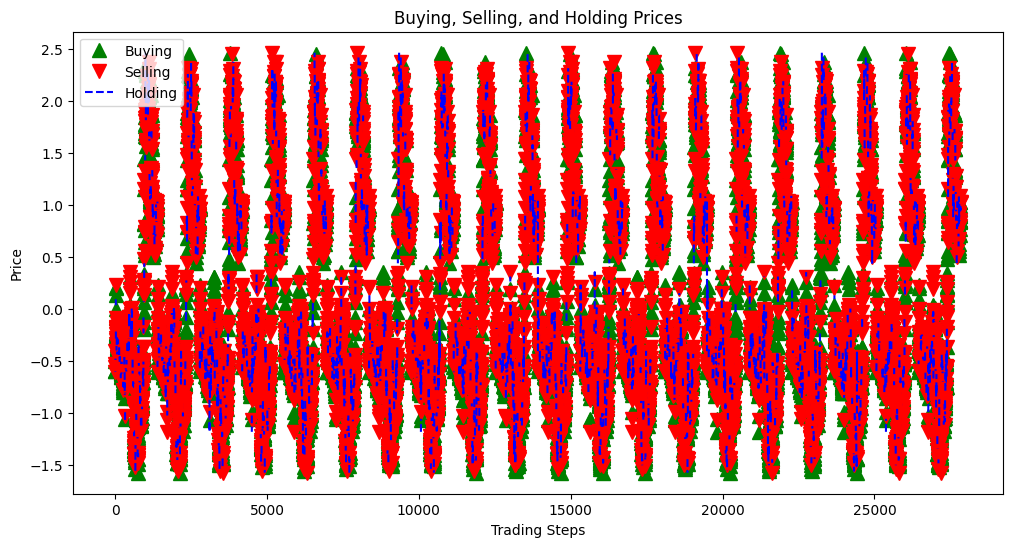

In [11]:
#-------start your code below this line-----------

# Plot Graph of buying, selling, and holding
plt.figure(figsize=(12, 6))
plt.plot(buying_prices, 'g^', markersize=10, label='Buying')
plt.plot(selling_prices, 'rv', markersize=10, label='Selling')
plt.plot(holding_prices, 'b--', label='Holding')
plt.xlabel('Trading Steps')
plt.ylabel('Price')
plt.title('Buying, Selling, and Holding Prices')
plt.legend()
plt.show()

# **Conclusion in 200 words**

*`------------write your conclusion below this line-------------------`*

Reinforcement learning is utilized by the Deep Double Q-Network (DDQN) agent in algorithmic trading. The agent gains the ability to make market-based trading decisions by being trained on past Ethereum data. The entire reward for each episode, which reflects the profitability of the strategy, is used to evaluate performance. The visualization of the agent's actions, costs, and initial investment sheds light on how it makes decisions. Hyperparameters and market conditions, however, can affect performance. Trading strategy and flexibility can be improved through optimization and experimentation.

Algorithmic trading is not without dangers and restrictions. Based on past statistics, the agent's performance might not translate to other markets. Making decisions based only on price data ignores other relevant information, such as news events, market sentiment, and economic indicators. To make well-informed trading judgments, one must integrate human judgment with risk management techniques and the agent's forecasts.

The current implementation is predicated on a single asset, a simpler trading environment, and the absence of slippage consideration or transaction charges. In practical situations, these elements have a big influence on profitability. Improvements could include more practical trading restrictions and conditions.

Finally, the DDQN agent shows how algorithmic trading can benefit from reinforcement learning. Algorithmic trading involves prudence, validation, ongoing monitoring, backtesting, and adaptability even if it can learn and make lucrative decisions. Algorithmic trading becomes an effective tool in intricate financial markets when it combines human experience, machine learning, and risk management.


References:
1. https://www.analyticsvidhya.com/blog/2021/01/bear-run-or-bull-run-can-reinforcement-learning-help-in-automated-trading/
2. https://github.com/ThibautTheate/An-Application-of-Deep-Reinforcement-Learning-to-Algorithmic-Trading/tree/main
3. https://medium.com/datapebbles/building-a-trading-bot-with-deep-reinforcement-learning-drl-b9519a8ba2ac